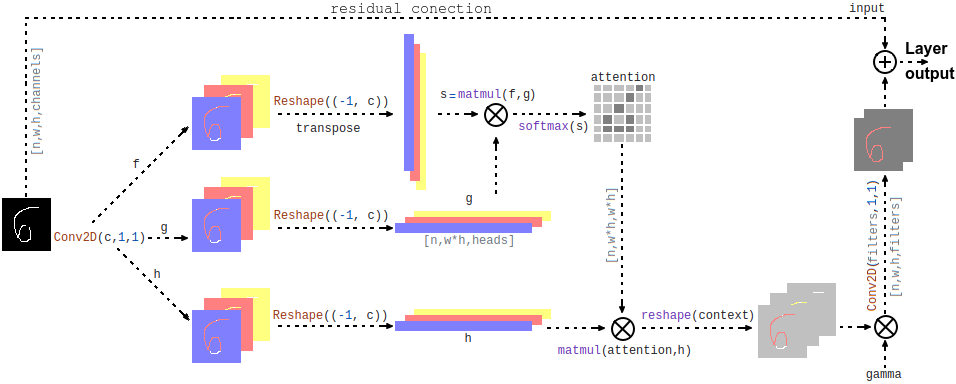

## Example of use with the MNIST dataset

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from custom_layer import SelfAttention_Conv2D

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.
x_train = x_train[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]

In [3]:
input = layers.Input((28, 28, 1))

x, scores = SelfAttention_Conv2D(8, activation='relu', num_heads=4, return_attention_scores=True)(input) # our layer

x = layers.Conv2D(32, (5, 5), activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation="relu")(x)
output = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=input, outputs=output)
attention_model = keras.Model(inputs=input, outputs=scores)

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 self_attention__conv2d (Sel  ((None, 28, 28, 8),      65        
 fAttention_Conv2D)           (None, 28, 28, 4))                 
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 32)        6432      
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 32)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 100)               460900

## Train the model

In [4]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)

epochs = 10
batch_size = 128

history = model.fit(x_train,
                    y_train,
                    validation_split=0.2,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/10
375/375 [==============================] - 24s 40ms/step - loss: 0.1895 - accuracy: 0.9419 - val_loss: 0.0751 - val_accuracy: 0.9766
Epoch 2/10
375/375 [==============================] - 14s 38ms/step - loss: 0.0559 - accuracy: 0.9822 - val_loss: 0.0585 - val_accuracy: 0.9845
Epoch 3/10
375/375 [==============================] - 14s 37ms/step - loss: 0.0358 - accuracy: 0.9894 - val_loss: 0.0511 - val_accuracy: 0.9855
Epoch 4/10
375/375 [==============================] - 14s 38ms/step - loss: 0.0254 - accuracy: 0.9919 - val_loss: 0.0545 - val_accuracy: 0.9853
Epoch 5/10
375/375 [==============================] - 15s 40ms/step - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.0514 - val_accuracy: 0.9870
Epoch 6/10
375/375 [==============================] - 14s 38ms/step - loss: 0.0142 - accuracy: 0.9953 - val_loss: 0.0473 - val_accuracy: 0.9872
Epoch 7/10
375/375 [==============================] - 15s 39ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.0507 - val_accuracy:

## Visualize results

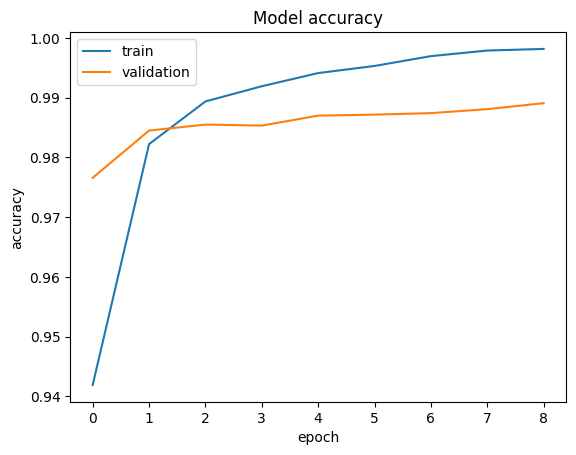

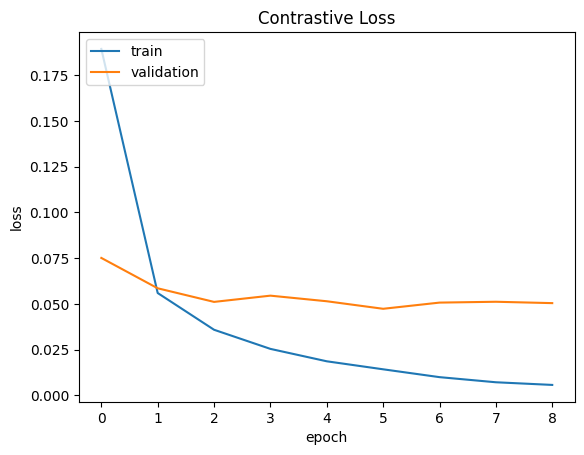

In [5]:
def plt_metric(history, metric, title, has_valid=True):
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

## Evaluate the model

In [6]:
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

313/313 [==============================] - 2s 6ms/step - loss: 0.0404 - accuracy: 0.9884
test loss, test acc: [0.04041048139333725, 0.9883999824523926]


## Attention weights

1/1 [==============================] - 0s 22ms/step


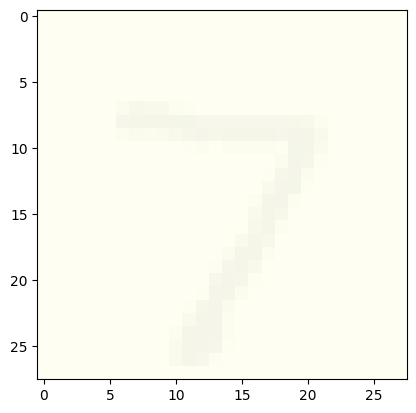

In [25]:
weights = attention_model.predict(x_test[0:1])
weights[0] = (weights[0] - np.min(weights[0]))/(np.max(weights[0])-np.min(weights[0]))

plt.figure()
plt.imshow(weights[0])
plt.show()

In [9]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# class SelfAttention_Conv2D(keras.layers.Layer):
#     def __init__(self, filters=None, num_heads=None, gamma=0.01, activation='linear', return_attention_scores=False, trainable=True):
#         super().__init__(trainable=trainable)
#         self.gamma = tf.Variable(initial_value=gamma, trainable=True, name='gamma')
#         self.f = None
#         self.g = None
#         self.h = None
#         self.v = None
#         self.attention = None
#         self.num_heads = num_heads
#         self.c = filters
#         self.activation = activation
#         self.scores = return_attention_scores

#     def build(self, input_shape):

#         if self.c is None:
#             self.c = input_shape[-1]

#         if self.num_heads is None:
#             self.num_heads = input_shape[-1]

#         self.f = self.block(self.num_heads) # [n, w*h, heads]
#         self.g = self.block(self.num_heads) # [n, w*h, heads]
#         self.h = self.block(self.num_heads) # [n, w*h, heads]

#         # output feature maps -> [n, w, h, filters]
#         self.v = layers.Conv2D(self.c, 1, 1, activation=self.activation)

#     @staticmethod
#     def block(c):
#         return keras.Sequential([
#             layers.Conv2D(c, 1, 1),   # [n, w, h, heads] 1*1conv
#             layers.Reshape((-1, c)),  # [n, w*h, heads]
#             ])

#     def call(self, inputs, **kwargs):
#         f = self.f(inputs)    # [n, w*h, heads]
#         g = self.g(inputs)    # [n, w*h, heads]
#         h = self.h(inputs)    # [n, w*h, heads]
#         s = tf.matmul(f, g, transpose_b=True)   # [n, w*h, heads] @ [n, heads, w*h] = [n, w*h, w*h]
#         self.attention = tf.nn.softmax(s, axis=-1)
#         context_wh = tf.matmul(self.attention, h)  # [n, w*h, w*h] @ [n, w*h, heads] = [n, w*h, heads]
#         d = inputs.shape        # [n, w, h, channels]
#         cs = context_wh.shape   # [n, w*h, heads]
#         context = self.gamma * tf.reshape(context_wh, [-1, d[1], d[2], cs[-1]])    # [n, w, h, c]
#         o = self.v(context) + inputs   # residual -> [n, w, h, filters]

#         if self.scores:
#             return o, context
#         else:
#             return o